In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = (SparkSession
    .builder
    .appName("panasonic-assignment")
    .getOrCreate())

In [3]:
rsu_schema = StructType([StructField('timestamp_bigint', LongType(), True),
             StructField('timestamp_utc', TimestampType(), True),
             StructField('rsu_id', StringType(), True),
             StructField('alert', StringType(), True)])

file_path = "/home/sova/panasonic/data/device_alerts.csv"
rsu_df = spark.read.csv(file_path, header=True, schema=rsu_schema)
rsu_df.cache()
rsu_df.printSchema()


root
 |-- timestamp_bigint: long (nullable = true)
 |-- timestamp_utc: timestamp (nullable = true)
 |-- rsu_id: string (nullable = true)
 |-- alert: string (nullable = true)



In [4]:
rsu_df.count()

3479

In [5]:
rsu_df.orderBy('timestamp_bigint').show(18, False)

+----------------+-------------------+------------------------------------+------------+
|timestamp_bigint|timestamp_utc      |rsu_id                              |alert       |
+----------------+-------------------+------------------------------------+------------+
|1593583215452   |2020-07-01 02:00:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
|1593583335091   |2020-07-01 02:02:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE        |
|1593583867309   |2020-07-01 02:11:07|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|
|1593607123410   |2020-07-01 08:38:43|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
|1593607170952   |2020-07-01 08:39:30|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE        |
|1593607574669   |2020-07-01 08:46:14|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|
|1593619442468   |2020-07-01 12:04:02|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
|1593619535172   |2020-07-01 12:05:35|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE        |
|1593619821456   |202

In [81]:
rsu_df.select('alert').distinct().show()

+------------+
|       alert|
+------------+
| RSU_OFFLINE|
| POE_OFFLINE|
|        NONE|
|SNMP_FAILURE|
+------------+



# 2. Draft description for the device_alerts view and each of its columns
## Assumptions
* This table represents stream of alerts each of them is signaling that device is online or offline
* Status is active begining from the alert time up to the recieving next alert.

## Table description
| Column Name | Data Type | Description |
| :- | :- | :- |
| timestamp_bigint | Long| Date/Time of alert in form of unix epoch with milliseconds|
| timestamp_utc | Timestamp(0)| Date/time of alert in UTC|
| rsu_id | String | Unique ID of rsu object|
| alert | String | Alert type {RSU_OFFLINE, POE_OFFLINE, SNMP_FAILURE, NONE}|

## Alert type
* RSU_OFFLINE - Road side unit is offline
* POE_OFFLINE - Power-over-Ethernet failure
* SNMP_FAILURE - Simple Network Management Protocol failure
* NONE - rsu works normally



In [82]:
rsu_df.createOrReplaceTempView('device_alerts')

In [83]:
spark.sql("""
select 
    t.*
  , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) as end_timestamp_utc
  , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) - timestamp_utc as elapsed_time
from device_alerts t
""").show(10)

+----------------+-------------------+--------------------+------------+-------------------+--------------------+
|timestamp_bigint|      timestamp_utc|              rsu_id|       alert|  end_timestamp_utc|        elapsed_time|
+----------------+-------------------+--------------------+------------+-------------------+--------------------+
|   1593583215452|2020-07-01 02:00:15|f943c318-26c8-45b...| POE_OFFLINE|2020-07-01 02:02:15|           2 minutes|
|   1593583335091|2020-07-01 02:02:15|f943c318-26c8-45b...|        NONE|2020-07-01 02:11:07|8 minutes 52 seconds|
|   1593583867309|2020-07-01 02:11:07|f943c318-26c8-45b...|SNMP_FAILURE|2020-07-01 08:38:43|6 hours 27 minute...|
|   1593607123410|2020-07-01 08:38:43|f943c318-26c8-45b...| POE_OFFLINE|2020-07-01 08:39:30|          47 seconds|
|   1593607170952|2020-07-01 08:39:30|f943c318-26c8-45b...|        NONE|2020-07-01 08:46:14|6 minutes 44 seconds|
|   1593607574669|2020-07-01 08:46:14|f943c318-26c8-45b...|SNMP_FAILURE|2020-07-01 12:04

In [84]:
df_hour = spark.sql("""
select 
    int(timestamp_bigint/1000/60/60/4) as alert_hour
from device_alerts t1
where alert != 'NONE'
""")
df_hour.cache()
df_hour.count()

1855

In [134]:
from pyspark.sql.functions import col, skewness, kurtosis
var = 'alert_hour'

df_hour.select(skewness(var),kurtosis(var)).show()

+--------------------+--------------------+
|skewness(alert_hour)|kurtosis(alert_hour)|
+--------------------+--------------------+
|-0.13773556167390577| -1.0139271244384689|
+--------------------+--------------------+



(array([ 2.,  0.,  2., 24.,  0.,  0., 20., 42., 47., 50., 56., 23.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0., 18., 42.,  0., 47., 35., 44., 43.,
        27.,  0.,  0.,  4., 24., 55., 24.,  0., 27., 51., 44., 50., 49.,
        45., 29., 53., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0., 16., 28.,  6., 55., 19.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0., 21., 16.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 47., 11., 42., 29.,
         0., 15.,  7.,  0.,  0.,  0.,  2.,  1.,  0.

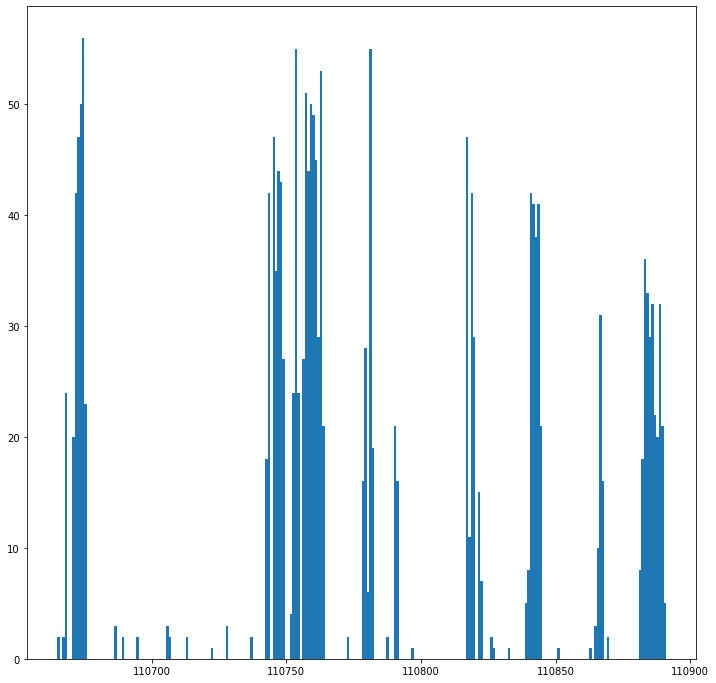

In [85]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
hist(ax, df_hour, bins=df_hour.select('alert_hour').distinct().count()*3)

In [86]:
df_hour_type = spark.sql("""
select
    case when alert = 'POE_OFFLINE' then event_time end as POE_OFFLINE
  , case when alert = 'SNMP_FAILURE' then event_time end as SNMP_FAILURE  
  , case when alert = 'RSU_OFFLINE' then event_time end as RSU_OFFLINE  
from 
(  
select 
    int(timestamp_bigint/1000/60/60/4) as event_time
    , alert
from device_alerts t1
where alert != 'NONE'
)
""")
# df_hour.cache()
# df_hour.count()

Text(0.5, 1.0, 'Alerts')

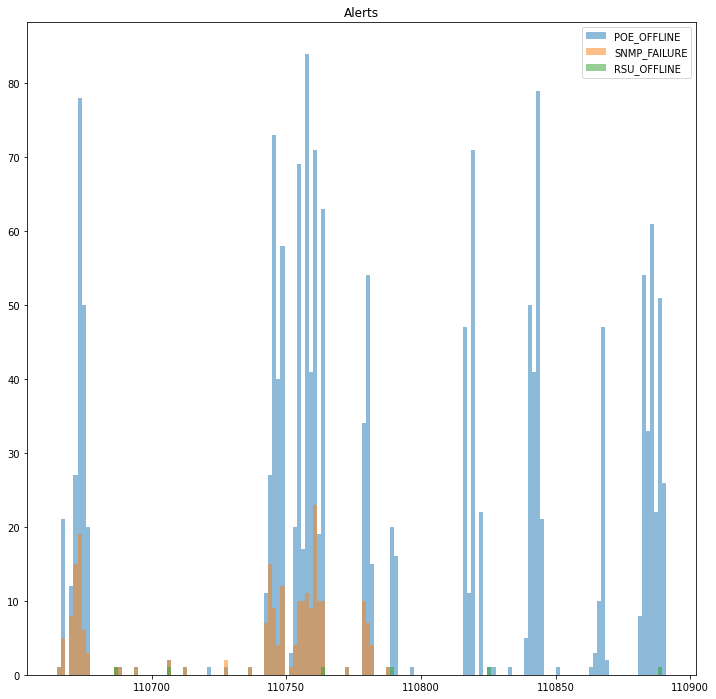

In [141]:
# fig, ax = plt.subplots(nrows=3, ncols=1)
fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
bins = 150
# hist(ax[0], df_hour_type.select(col('POE_OFFLINE')), bins=bins)
# hist(ax[1], df_hour_type.select(col('SNMP_FAILURE')), bins=bins, color='red')
# hist(ax[2], df_hour_type.select(col('RSU_OFFLINE')), bins=bins, color='green')

POE_OFFLINE = df_hour_type.select(col('POE_OFFLINE'))
SNMP_FAILURE = df_hour_type.select(col('SNMP_FAILURE'))
RSU_OFFLINE = df_hour_type.select(col('RSU_OFFLINE'))

hist(ax, [POE_OFFLINE, SNMP_FAILURE, RSU_OFFLINE], bins=bins, overlapping=True)
labels = ['POE_OFFLINE', 'SNMP_FAILURE', 'RSU_OFFLINE']
ax.legend(labels)
ax.set_title('Alerts')


In [95]:
spark.sql("""
select 
    from_unixtime(Decimal(int(timestamp_bigint/1000/60/60/4)) * 60 * 60 * 4,"yyyy-MM-dd HH:mm:ss")  as alert_hour
  , count(*) as cnt
from device_alerts t1
where alert != 'NONE'
group by 1
order by 2 desc, 1
""").show(3, False)

+-------------------+---+
|alert_hour         |cnt|
+-------------------+---+
|2020-07-02 16:00:00|56 |
|2020-07-15 20:00:00|55 |
|2020-07-20 08:00:00|55 |
+-------------------+---+
only showing top 3 rows



## 3. What are the 4 hours in the time range with the most alerts triggered

### Simple 4 hour windowing
<b>4 hours between 2020/07/02 4pm and 8 pm had the most number of alerts equal to 56</b>
<br>

* Dataset already contains alert event in epoch format that is why we can easily split it on 4 hour buckets by deviding timestamp_bigint on number of milliseconds in this 4 hours and discarding fractional part and than moving back to epoch time but without milliseconds as we do not need such precision
* Also we need to filter out alert type NONE as accourding to the asumptions it means that RSU is alive and not actually a health alert but rather signals that previous alert has completed
* After that we just need to count events in each `window` and get the time with the largest result
```SQL
+-------------------+---+
|alert_hour         |cnt|
+-------------------+---+
|2020-07-02 16:00:00|56 |
|2020-07-15 20:00:00|55 |
|2020-07-20 08:00:00|55 |
+-------------------+---+

select 
    from_unixtime(Decimal(int(timestamp_bigint/1000/60/60/4)) * 60 * 60 * 4,"yyyy-MM-dd HH:mm:ss")  as alert_hour
  , count(*) as cnt
from device_alerts t1
where alert != 'NONE'
group by 1
order by 2 desc, 1
```
### Rolling 4 hour windowing
The other approach would be to count event on the rolling basis
* For each event we are loking 4 hours behind using self join 
* As with previous approach all NONE alerts have to be filtered out
* Lastly counting number of alerts within 4 hour and take the largest results
<br>
<b>Using this approach we are getting 5 windows with 58 alerts each</b>
```
+-------------------+-------------------+----------+
|first_alert_ts     |last_alert_ts      |cnt_alerts|
+-------------------+-------------------+----------+
|2020-07-02 15:46:12|2020-07-02 19:46:09|58        |
|2020-07-02 15:53:41|2020-07-02 19:51:13|58        |
|2020-07-17 08:19:17|2020-07-17 12:18:57|58        |
|2020-07-20 07:40:29|2020-07-20 11:40:09|58        |
|2020-07-20 07:44:20|2020-07-20 11:42:40|58        |
+-------------------+-------------------+----------+

with vlt_alerts as
(
    select timestamp_bigint, timestamp_utc, rsu_id
    from device_alerts
    where alert != 'NONE'
)
SELECT 
  min(t1.timestamp_utc) as first_alert_ts
, t.timestamp_utc as last_alert_ts
, count(*) as cnt_alerts
FROM vlt_alerts t, vlt_alerts t1
WHERE 
    t.rsu_id = t1.rsu_id
and t1.timestamp_bigint between t.timestamp_bigint - 4*60*60*1000 and t.timestamp_bigint 
group by 2
order by cnt_alerts desc, 1
```

In [101]:
spark.sql("""
with vlt_alerts as
(
    select timestamp_bigint, timestamp_utc, rsu_id
    from device_alerts
    where alert != 'NONE'
)
SELECT 
  min(t1.timestamp_utc) as first_alert_ts
, t.timestamp_utc as last_alert_ts
, count(*) as cnt_alerts
FROM vlt_alerts t, vlt_alerts t1
WHERE 
    t.rsu_id = t1.rsu_id
and t1.timestamp_bigint between t.timestamp_bigint - 4*60*60*1000 and t.timestamp_bigint 
group by 2
order by cnt_alerts desc, 1
""").show(10, False)

+-------------------+-------------------+----------+
|first_alert_ts     |last_alert_ts      |cnt_alerts|
+-------------------+-------------------+----------+
|2020-07-02 15:46:12|2020-07-02 19:46:09|58        |
|2020-07-02 15:53:41|2020-07-02 19:51:13|58        |
|2020-07-17 08:19:17|2020-07-17 12:18:57|58        |
|2020-07-20 07:40:29|2020-07-20 11:40:09|58        |
|2020-07-20 07:44:20|2020-07-20 11:42:40|58        |
|2020-07-20 07:51:11|2020-07-20 11:50:12|58        |
|2020-07-02 14:26:08|2020-07-02 18:25:27|57        |
|2020-07-02 14:41:07|2020-07-02 18:38:38|57        |
|2020-07-02 14:42:32|2020-07-02 18:41:09|57        |
|2020-07-02 14:45:04|2020-07-02 18:43:00|57        |
+-------------------+-------------------+----------+
only showing top 10 rows



In [102]:
df_hour = spark.sql("""
select 
    extract(hour from timestamp_utc) as alert_hour
from device_alerts t1
where alert != 'NONE'
""")
df_hour.cache()
df_hour.count()

1855

(array([0.09000352, 0.        , 0.06075237, 0.        , 0.09562874,
        0.        , 0.04050158, 0.        , 0.04500176, 0.        ,
        0.04950193, 0.        , 0.04725185, 0.        , 0.09112856,
        0.        , 0.11137935, 0.        , 0.11475448, 0.        ,
        0.13725536, 0.        , 0.11137935, 0.        , 0.        ,
        0.10012891, 0.        , 0.07650299, 0.        , 0.09337865,
        0.        , 0.08887847, 0.        , 0.07762803, 0.        ,
        0.08887847, 0.        , 0.09900387, 0.        , 0.09675378,
        0.        , 0.10350404, 0.        , 0.0922536 , 0.        ,
        0.08775343, 0.        , 0.08775343]),
 array([ 0.        ,  0.47916667,  0.95833333,  1.4375    ,  1.91666667,
         2.39583333,  2.875     ,  3.35416667,  3.83333333,  4.3125    ,
         4.79166667,  5.27083333,  5.75      ,  6.22916667,  6.70833333,
         7.1875    ,  7.66666667,  8.14583333,  8.625     ,  9.10416667,
         9.58333333, 10.0625    , 10.54166667, 11.

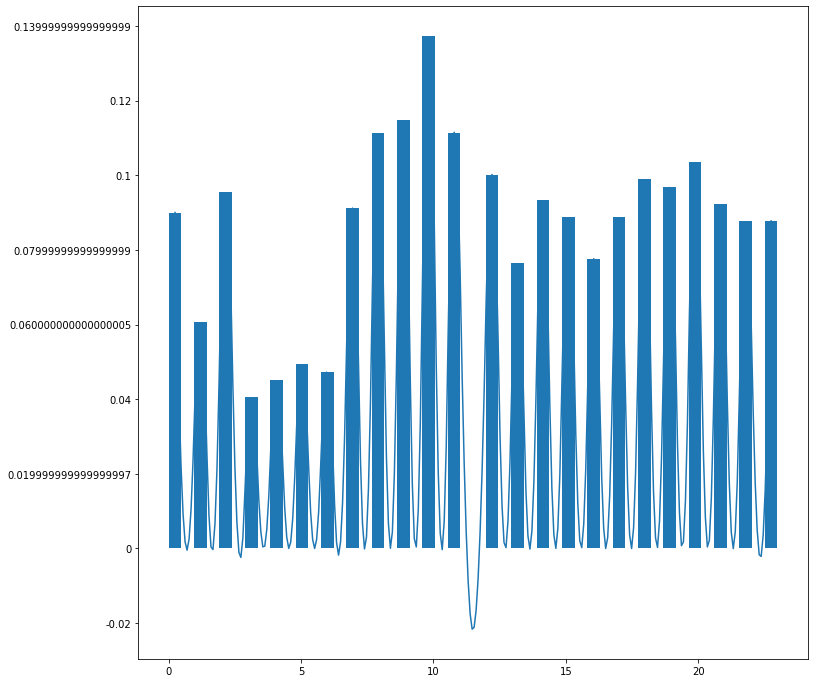

In [115]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
hist(ax, df_hour, bins=df_hour.select('alert_hour').distinct().count())

In [107]:
spark.sql("""
select 
    extract(hour from timestamp_utc) as alert_hour
  , count(*)
from device_alerts t1
where alert != 'NONE'
group by 1
order by 1
""").show(30)

+----------+--------+
|alert_hour|count(1)|
+----------+--------+
|         0|      80|
|         1|      54|
|         2|      85|
|         3|      36|
|         4|      40|
|         5|      44|
|         6|      42|
|         7|      81|
|         8|      99|
|         9|     102|
|        10|     122|
|        11|      99|
|        12|      89|
|        13|      68|
|        14|      83|
|        15|      79|
|        16|      69|
|        17|      79|
|        18|      88|
|        19|      86|
|        20|      92|
|        21|      82|
|        22|      78|
|        23|      78|
+----------+--------+



In [ ]:

# (rsu_df.filter(col('alert') != 'NONE')).createOrReplaceTempView('RSU_ALERTS')

In [ ]:
spark.sql("""
select 
    t.timestamp_utc
  , max(t1.timestamp_utc) as end_timestamp_utc
  , count(*)
  --timestamp_utc, timestamp_utc + interval 4 hours as end_window, timestamp_bigint, timestamp_bigint + 4*60*60*1000 
from RSU_ALERTS t
join RSU_ALERTS t1
on
    -- t.rsu_id != t1.rsu_id and
--and t1.timestamp_bigint between t.timestamp_bigint and t.timestamp_bigint + 4*60*60*1000
t1.timestamp_utc between t.timestamp_utc and (t.timestamp_utc + interval 4 hours)
group by t.timestamp_utc
-- where t.rsu_id = 1594404850837
order by 3 desc
  """).show()

In [ ]:
spark.sql("""
select 
    min(timestamp_utc)
  , max(timestamp_utc)
  , count(*)
  , four_hour_window
from (
select 
    *
  , int((timestamp_bigint - start_timestamp) / (4*60*60*1000)) as four_hour_window
  --, max(t1.timestamp_utc) as end_timestamp_utc
  --, count(*)
  --timestamp_utc, timestamp_utc + interval 4 hours as end_window, timestamp_bigint, timestamp_bigint + 4*60*60*1000 
from RSU_ALERTS t
join (select min(timestamp_bigint) as start_timestamp from RSU_ALERTS) t1
)
group by four_hour_window
order by 3 desc
  """).show()

In [ ]:
rsu_df.orderBy('timestamp_bigint').show()

In [ ]:
spark.sql("""
select 
alert, sum(time_event) from(
select
    timestamp_bigint
  , lead(timestamp_bigint) over (partition by rsu_id order by timestamp_bigint) - timestamp_bigint as time_event
  , alert

from RSU_STREAM
)
group by alert
""").show()

In [ ]:
spark.sql("""

select
    lead(timestamp_bigint) over (partition by rsu_id order by timestamp_bigint) - timestamp_bigint as time_event
  , t.*
  , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) - timestamp_utc as end_timestamp_utc
from RSU_STREAM t
order by 1 desc
""").show(30)

In [7]:
rsu_df.groupBy('alert').count().show()
rsu_df.agg({'alert': 'count'}).show()

+------------+-----+
|       alert|count|
+------------+-----+
| RSU_OFFLINE|    6|
| POE_OFFLINE| 1625|
|        NONE| 1624|
|SNMP_FAILURE|  224|
+------------+-----+

+------------+
|count(alert)|
+------------+
|        3479|
+------------+

